# Conformal prediction of molecule-induced cancer cell growth inhibition challenged by strong distribution shifts 

Code to replicate results from Fig. 6 The ensemble of CP models can predict the selectivity of a dissimilar molecule across NCI-60 cell lines. 

In [1]:
# Libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno


from collections import Counter
from sklearn.metrics import  mean_squared_error
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score


from scipy import stats  # for Rp and Rs

In [2]:
from matplotlib.patches import Patch

## Functions 

In [3]:
 
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def get_rp(y_true, y_pred):
    """
    Pearson correlation
    The Pearson correlation coefficient measures the linear relationship between two datasets. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.
    """
    r = stats.pearsonr(y_true, y_pred)
    return r[0]


def get_rs(y_true, y_pred):
    """ 
    Spearman correlation
    The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.
    """
    return stats.spearmanr(y_true, y_pred).correlation


In [7]:
# Read and merge the predictions per cluster

def read_one_cell_line_test(cell, dir_main, cp_model=['RF', 'RF'], c_lvl='80'):    
    dir_cell_aux = dir_main+'/'+cp_model[0]+'_'+cp_model[1]+'/CELL_LINE_'+cell
    dir_cell_in = dir_cell_aux + '/predictions/confidence_'       
    data_in = dir_cell_in + c_lvl + '/' + cell + '_OUTLIERS_CL_' + c_lvl + '.feather'
    df_one_cell_test = pd.read_feather(data_in)
    df_one_cell_test['CP-valid prediction'] = np.where(
        (df_one_cell_test['Observed pGI50'] >= df_one_cell_test['min']) & (df_one_cell_test['Observed pGI50'] <= df_one_cell_test['max']), 'CP-valid', 'CP-invalid')
    df_one_cell_test['Potency'] = np.where(df_one_cell_test['Predicted pGI50'] >= 6, 'highPotency', 'lowPotency')
    # add cell name -- to easy read
    df_one_cell_test['Cell line'] = cell    
    return df_one_cell_test



In [8]:
def get_sparcity_nsc_across_cells(df_all_cells_cond, df_matrix_nan):
    for c in df_all_cells_cond['Cell line'].unique():
        df_aux = df_all_cells_cond[df_all_cells_cond.loc[:, 'Cell line'] == c]
        df_aux_c = df_aux.loc[:, ['NSC']]
        df_aux_c.rename(columns={"NSC": c}, inplace=True)
        # Reset index
        df_aux_c.reset_index(drop=True)
        # Merge on the right each df_nsc per cell line
        df_matrix_nan = df_matrix_nan.merge(df_aux_c, how='left', left_on='uniqueNSC', right_on=c)
    
    df_matrix_sort = df_matrix_nan.sort_values(by=['uniqueNSC'])
    df_matrix_sort.reset_index(drop=True, inplace=True)
    return df_matrix_sort



def get_unique_nsc_across_cells_onemodel(cells, dir_test, cp_model=['RF', 'RF'],
                                         c_lvl='80', cp_valid=True, highpotency=True):
    """
    return: DF with all cells lines (df_all_cells), and DF with the sparcity of the NSC across cells
    """
    list_df_cell = []
    # Load all cell lines predictions
    print('MODEL: ', cp_model[0], '-', cp_model[-1])
    for cell in cells:
        # print('Cell: ', cell)
        df_one_c = read_one_cell_line_test(cell=cell, dir_main=dir_test, cp_model=cp_model, c_lvl=c_lvl)
        list_df_cell.append(df_one_c)    
    
    # Concat all dataframes
    df_all_cells = pd.concat(list_df_cell, ignore_index=True, copy=False)
    print('\t(ALL cell lines) Shape dataframe concated: ', df_all_cells.shape)
    # Conditions to look for the NSC across cell lines
    if cp_valid:
        df_all_cells = df_all_cells[df_all_cells.loc[:, 'CP-valid prediction'] == 'CP-valid']
    if highpotency:
        df_all_cells = df_all_cells[df_all_cells.loc[:, 'Potency'] == 'highPotency']
    print('\n\t(After MP and CPvalid) Shape dataframe concated: ', df_all_cells.shape)
    print('\t\tUnique NSCs across 60 cell lines:', len(df_all_cells.NSC.unique()),
          '\n\t\tUnique Cell lines: ', len(df_all_cells['Cell line'].unique()))    
    # Get unique NSC
    nsc_col = df_all_cells.NSC.unique()
    df_matrix_aux = pd.DataFrame(data=nsc_col, columns=['uniqueNSC'])
    df_matrix_sorted = get_sparcity_nsc_across_cells(df_all_cells_cond=df_all_cells,
                                                     df_matrix_nan=df_matrix_aux)
    return df_all_cells, df_matrix_sorted
   


In [9]:
def get_values_to_select_best_nsc(nsc_candidates, df_nsc_cand):
    # get the rmseand the average size (efficiency) per NSC
    list_rmse_per_nsc = []
    print('Get metrics per NSC...')
    for n in nsc_candidates:
        # print('NSC: ', n)
        df_obs_pred = df_nsc_cand[df_nsc_cand.loc[:, 'NSC'] == n]
        
        prediction = df_obs_pred.loc[:, 'Predicted pGI50'].to_numpy()  # prediction value
        y = df_obs_pred.loc[:, 'Observed pGI50'].to_numpy()            # true value 
        
        avg_eff = np.mean(df_obs_pred['size'].to_numpy())
        rmse_nsc = rmse(y, prediction)
        rp_nsc = get_rp(y, prediction)
        rs_nsc = get_rs(y, prediction)
        list_rmse_per_nsc.append([n, rmse_nsc, rp_nsc, rs_nsc, avg_eff, len(y)])
    df_best_nsc_cond = pd.DataFrame(data=list_rmse_per_nsc, 
                                    columns=['NSC', 'RMSE', 'Rp', 'Rs', 'AVG Size', 'NumberCells'])
    return df_best_nsc_cond


def get_median_aux(df, col_n):
    df_new = df.sort_values(by=[col_n], ignore_index=True)
    f, c = df_new.shape
    n = int((f/2)-1)
    df_median = df_new.iloc[[n], :]
    return df_median


def get_best_nsc_candidates(df_matrix_sort, df_nsc_allcells, min_num_cells=50):
    """
    Return: df_drop_thresh5: To see the sparcity of the selected cell lines,
            df_best_nsc: to compare the other options,
            df_pvs: to plot the PVS (best NSC across cell lines) #rows equal to cell lines with the NSC present
    """
    # Remove the first column
    df_nsc_cells_1 = df_matrix_sort.drop(columns=['uniqueNSC'])
    
    # Keep cell lines where the NSC appears in at least min_mun_cells
    print('Getting NSC present in at least ', min_num_cells, ' cells')
    df_drop_thresh5 = df_nsc_cells_1.dropna(thresh=min_num_cells)
    
    # Get the nsc candidates    
    if df_drop_thresh5.iloc[:, 0].isnull().values.any(): # if there is a NSC equal to NaN
        nsc_aux = df_drop_thresh5.mean(axis=1).to_list() # mean omits NaN and all columns have the same values
    else:
        nsc_aux = df_drop_thresh5.iloc[:, 0].to_list()
    nsc_candidates = [int(i) for i in nsc_aux]  # to turn into int numbers
    print('NSC candidates: ', len(nsc_candidates))
    
    # Get the cell lines that match the NSC candidates
    df_nsc_cand = df_nsc_allcells[df_nsc_allcells.loc[:, 'NSC'].isin(nsc_candidates)]
    
    # get the final values to select the best NSC
    df_best_nsc = get_values_to_select_best_nsc(nsc_candidates=nsc_candidates,
                                                df_nsc_cand=df_nsc_cand)

    # Get the best value
    df_condition_b = df_best_nsc[df_best_nsc.loc[:, cond_b] == df_best_nsc[cond_b].min()]
    best_nsc = df_condition_b['NSC'].values[0]  # all the nsc are the same here
    
    # get the dataframe with the cell lines that match the best NSC
    df_pvs = df_nsc_cand[df_nsc_cand.loc[:, 'NSC'] == best_nsc]     
    return df_drop_thresh5, df_best_nsc, df_pvs



##  - - 

## Dataset

In [11]:
# MAIN FOLDER

# Replace 
dir_test = '/home/hernadez/Documents/conformal_prediction/retrainSTL_LDMO/'


In [13]:
# 60 cell lines
cells = ['MCF7', 'MDA-MB-231_ATCC' ,'HS_578T', 'BT-549', 'T-47D',
         'COLO_205', 'HCC-2998', 'HCT-116', 'HCT-15','HT29', 'KM12','SW-620',
         'SF-268','SF-295','SF-539','SNB-19', 'SNB-75', 'U251',
         'CCRF-CEM', 'HL-60(TB)','K-562','MOLT-4','RPMI-8226','SR',
         'A549_ATCC','EKVX','HOP-62','HOP-92','NCI-H226','NCI-H23','NCI-H322M','NCI-H460','NCI-H522',
         'LOX_IMVI','MALME-3M','M14', 'SK-MEL-2','SK-MEL-28','SK-MEL-5','UACC-257','UACC-62','MDA-MB-435','MDA-N',
         'IGROV1','OVCAR-3','OVCAR-4', 'OVCAR-5', 'OVCAR-8', 'SK-OV-3','NCI_ADR-RES',
         'PC-3', 'DU-145',
         '786-0','A498','ACHN','CAKI-1','RXF_393', 'SN12C','TK-10','UO-31']



In [16]:
hx = 'XGB'
gx = 'RF'

cp_valid= True
most_potent=True



In [17]:
# Get info

df_nsc_allcells, df_matrix_sort = get_unique_nsc_across_cells_onemodel(cells=cells, dir_test=dir_test,
                                                                       cp_model=[hx, gx], c_lvl='80',
                                                                       cp_valid=cp_valid, 
                                                                       highpotency=most_potent)


MODEL:  RF - RF
	(ALL cell lines) Shape dataframe concated:  (933261, 13)

	(After MP and CPvalid) Shape dataframe concated:  (5252, 13)
		Unique NSCs across 60 cell lines: 301 
		Unique Cell lines:  60


### Molecules present in at least n cell lines

In [31]:
df_drop_thresh5, df_best_nsc_cond, df_pvs = get_best_nsc_candidates(df_matrix_sort=df_matrix_sort,
                                                                    df_nsc_allcells=df_nsc_allcells,
                                                                    min_num_cells=50)



Getting NSC present in at least  50  cells
NSC candidates:  37
Get metrics per NSC...

 Get the best NSC...


In [36]:
cond_bw = 'AVG Size' 
print('Sorting by: ', cond_bw)

df_best_nsc_cond.sort_values(by=[cond_bw])  



Sorting by:  AVG Size


,NSC,RMSE,Rp,Rs,AVG Size,NumberCells
33,747457,0.260351,0.798141,0.788533,1.804371,52
16,251190,0.402165,0.770617,0.809459,1.851066,50
30,693571,0.467972,0.767531,0.752342,1.931085,51
9,82151,0.190772,0.895575,0.858662,1.959297,59
10,83142,0.454256,0.804847,0.847689,2.034104,56
12,125973,0.235919,0.915316,0.882676,2.223429,54
20,624285,0.403946,0.538638,0.535398,2.401913,53
29,690977,0.458036,0.586108,0.685807,2.628173,51
35,751817,0.693135,0.780082,0.785284,2.698942,58
0,757,0.403326,0.570748,0.711377,2.770954,52


## Plot across 60 cell lines 

In [41]:
# TITLE PLOT 
nsc_best_name = df_pvs['NSC'].to_list()[0]
title_plot = 'Best NSC: ' + str(nsc_best_name)


In [44]:
metric_info_plot = df_best_nsc_cond[df_best_nsc_cond.loc[:,'NSC'] == nsc_best_name]

metric_info_plot

,NSC,RMSE,Rp,Rs,AVG Size,NumberCells
33,747457,0.260351,0.798141,0.788533,1.804371,52


In [45]:
x = df_pvs['Cell line'].to_list()
x_aux = [i for i in range(len(x))]

y_1 = df_pvs['Observed pGI50'].to_list()
y_2 = df_pvs['Predicted pGI50'].to_list()
y_3 = df_pvs['min'].to_list()
y_4 = df_pvs['max'].to_list()


 CP model: RF-RF 
 Best NSC: 747457 (AVG Size)


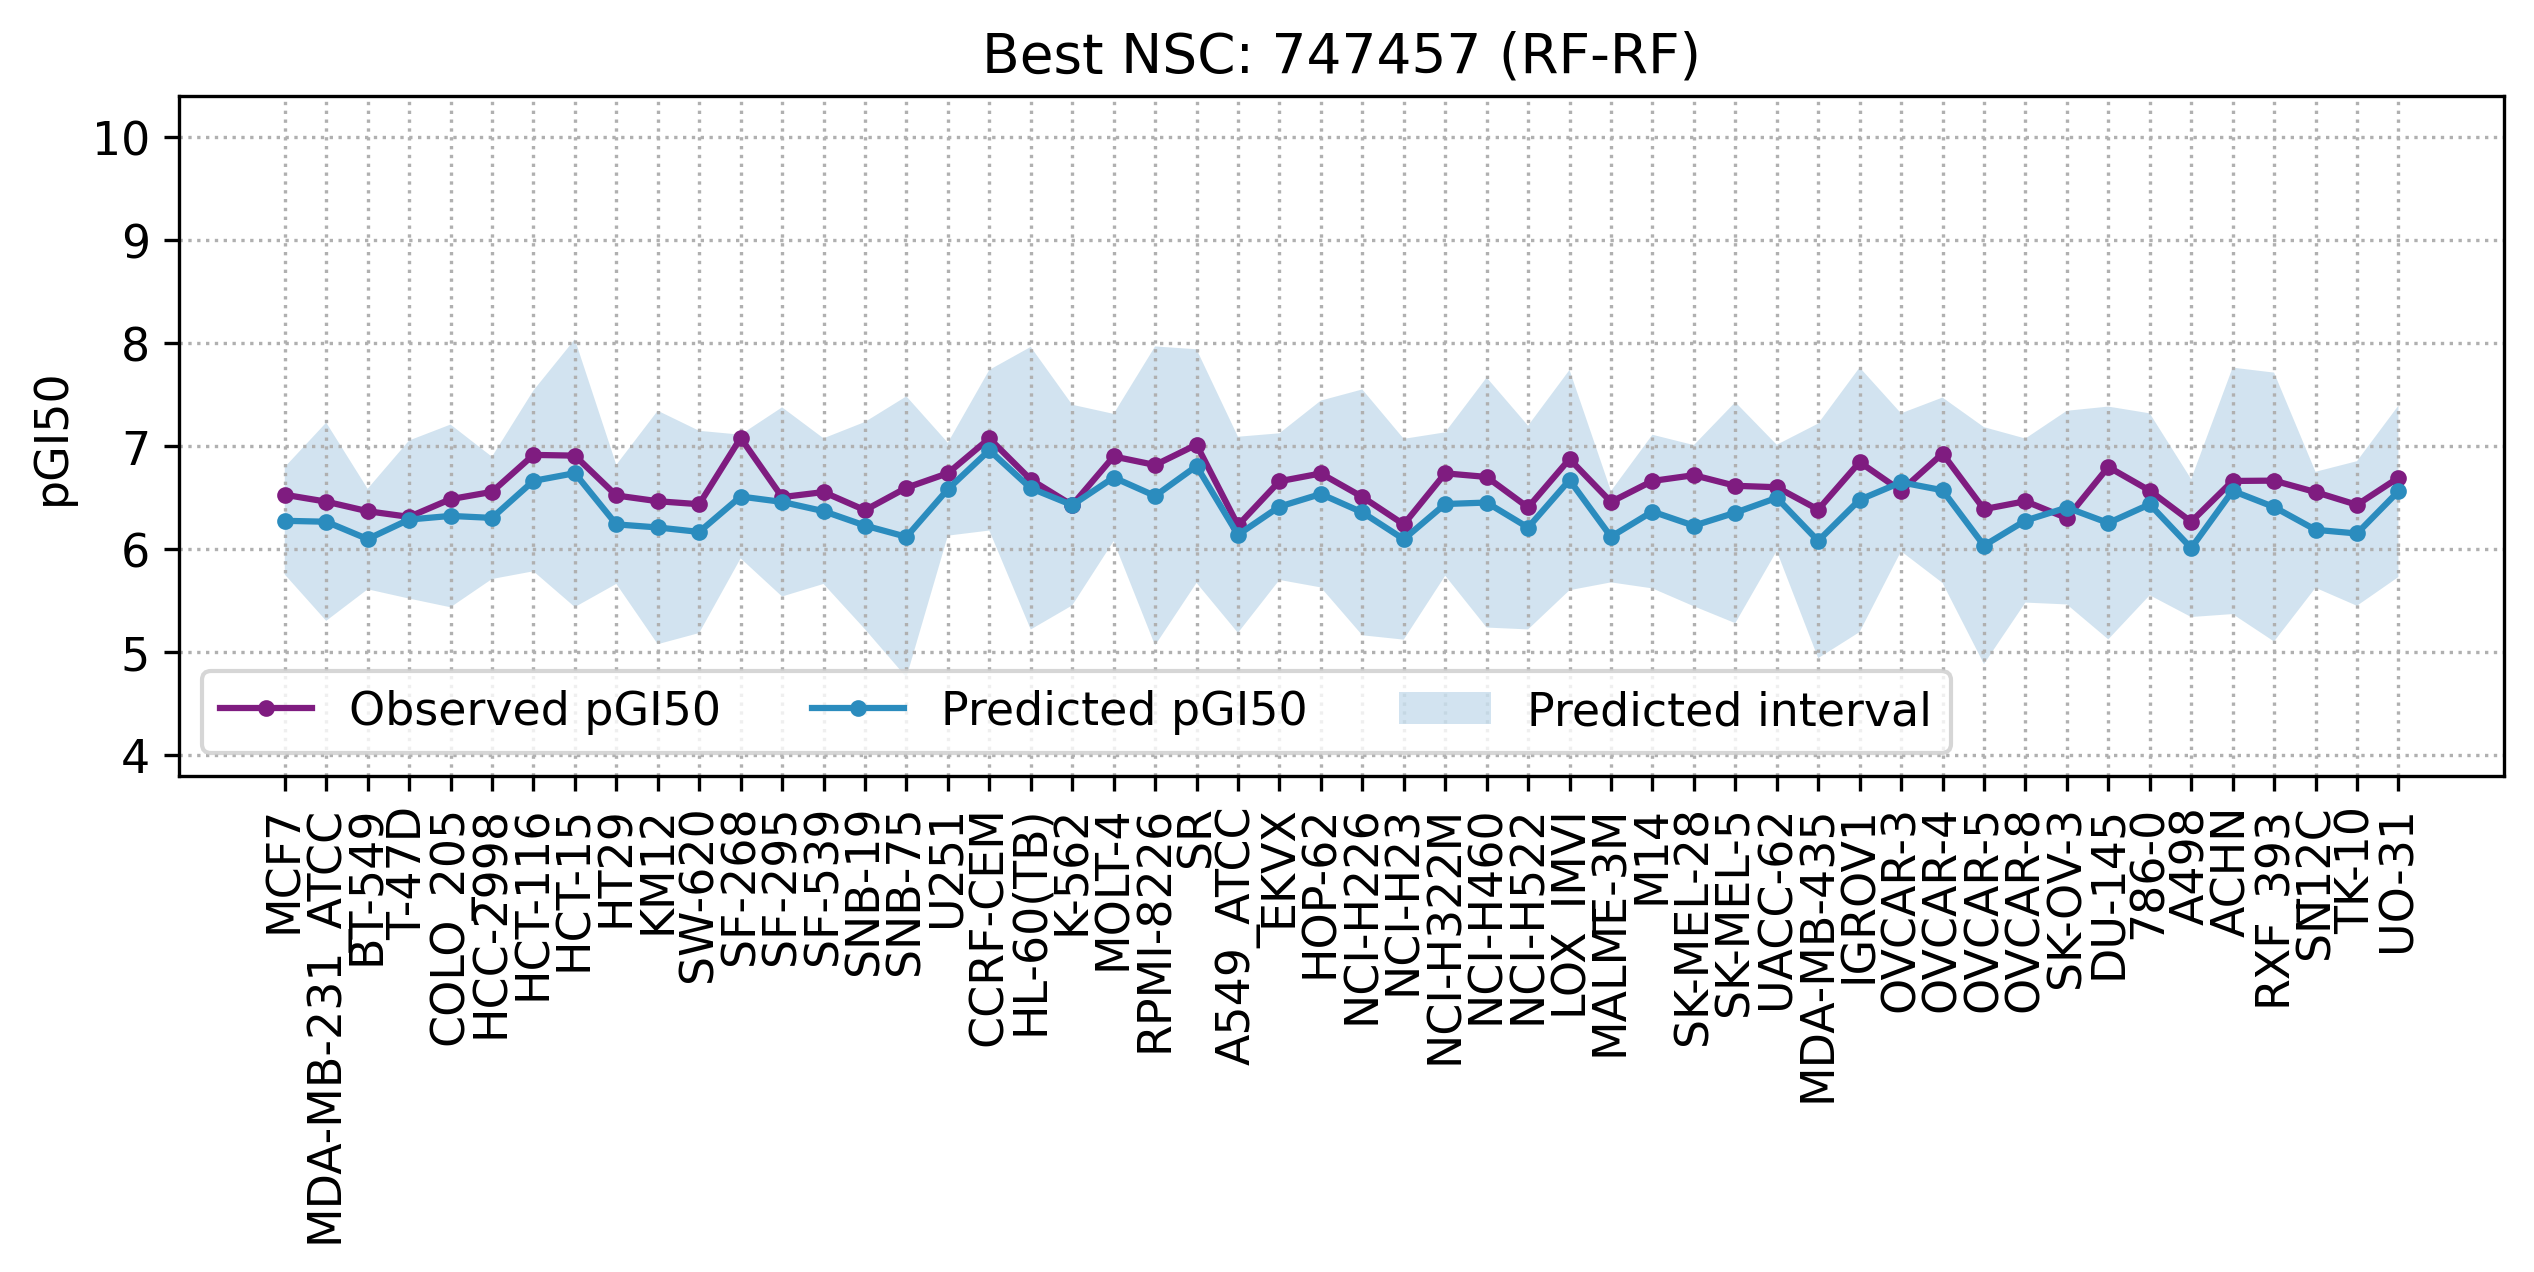

In [46]:
plt.rcParams['font.size'] = 11

fig, ax = plt.subplots(figsize=(10, 3), dpi=300)   
ax.plot(x_aux, y_1, marker='.', c='#7f1c80', label='Observed pGI50')
ax.plot(x_aux, y_2, marker='.', c='#2b8cbe', label='Predicted pGI50')
ax.fill_between(x, y_3, y_4, alpha=0.2, label='Predicted interval')

plt.ylim([3.8, 10.4])
plt.ylabel('pGI50')
plt.xticks(x_aux, x, rotation='vertical')
plt.grid(which='both', linestyle=':', linewidth=0.8)   

ax.legend(loc='lower left', ncol=3)   
plt.xlabel(None)

plt.title(title_plot+' ('+hx+'-'+gx+')')  
plt.show()



In [47]:
textstr = "Avg uncertainty: " + str(round(metric_info_plot['AVG Size'].values[0], 2))
textstr = textstr + '\nRMSE: '+str(round(metric_info_plot['RMSE'].values[0], 3))
textstr = textstr + '\nRp: '+str(round(metric_info_plot['Rp'].values[0], 3))
textstr = textstr + '\nRs: '+str(round(metric_info_plot['Rs'].values[0], 3))
textstr = textstr + '\nCells: '+str(metric_info_plot['NumberCells'].values[0])

textstr

'Avg uncertainty: 1.8\nRMSE: 0.26\nRp: 0.798\nRs: 0.789\nCells: 52'

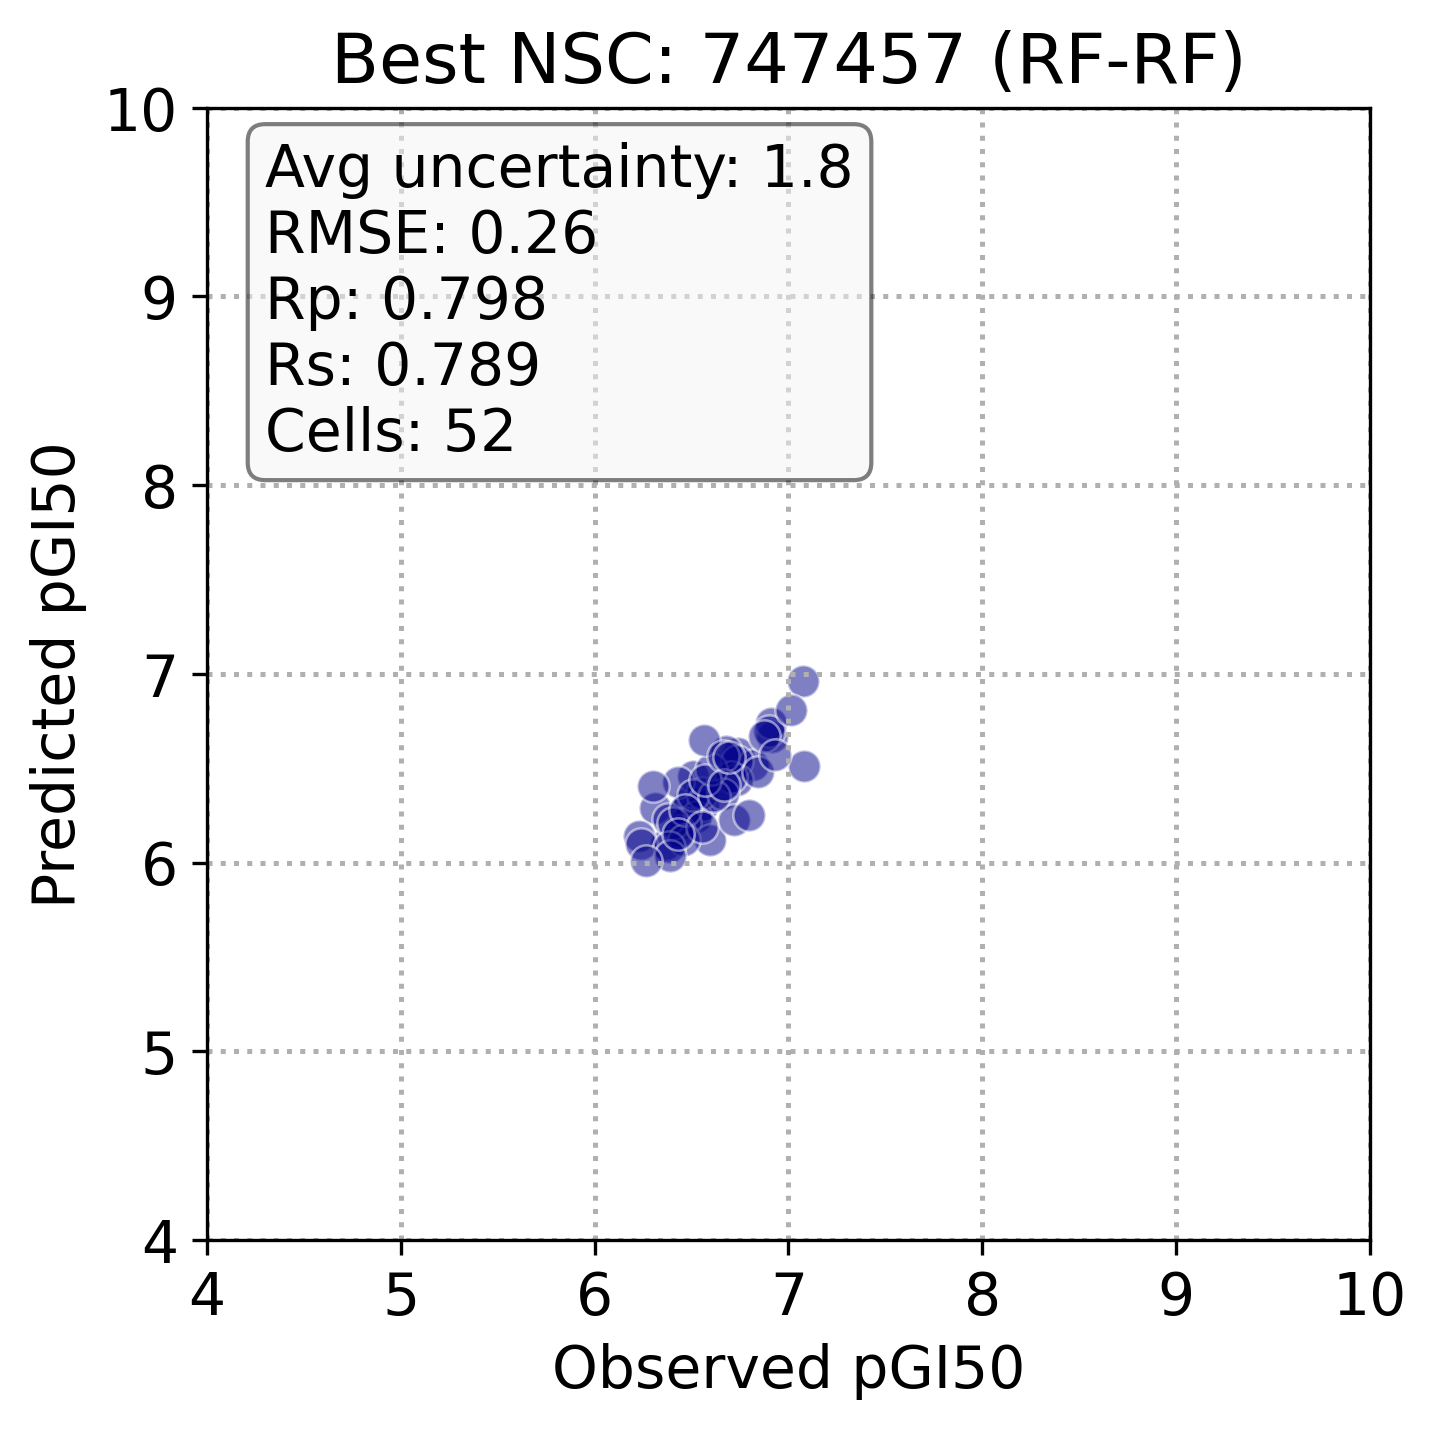

In [48]:
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(5,5), dpi=300)

sns.scatterplot(data=df_pvs, x='Observed pGI50', y='Predicted pGI50',
                s=60, color='darkblue', ax=ax, alpha=0.5)  #  

# To place the metrics information
props = dict(boxstyle='round', facecolor='whitesmoke', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.97, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props) 

plt.xlim([4, 10])
plt.ylim([4, 10])


plt.grid(which='both', linestyle=':', linewidth=1.2,)   # 
plt.title(title_plot+' ('+hx+'-'+gx+')' )  # +' ('+cond_bw+')'
plt.show()

